# Assignment 8: DT

<ol>
    <li><strong>Apply Decision Tree Classifier(DecisionTreeClassifier) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features +  preprocessed_eassay (TFIDF)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features +  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation(use gridsearch cv or randomsearch cv)/simple cross validation data(you can write your own for loops refer sample solution)</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>min_sample_split</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
    <li>Once after you plot the confusion matrix with the test data, get all the `false positive data points`
        <ul>
            <li> Plot the WordCloud(https://www.geeksforgeeks.org/generating-word-cloud-python/) with the words of essay text of these `false positive data points`</li>
            <li> Plot the box plot with the `price` of these `false positive data points`</li>
            <li> Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`</li>
        </ul>
        </ul>
    </li>
   <li><b>Task 2: </b>For this task consider set-1 features. Select all the features which are having non-zero feature importance.You can get the feature importance using  'feature_importances_` 
   (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), discard the all other remaining features and then apply any of the model of you choice i.e. (Dession tree, Logistic Regression, Linear SVM), you need to do hyperparameter tuning corresponding to the model you selected and procedure in step 2 and step 3<br>
  Note: when you want to find the feature importance make sure you don't use max_depth parameter keep it None.
  </li>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.sparse import hstack
from sklearn.metrics import roc_auc_score,auc

import pickle

from tqdm import tqdm
import os
from chart_studio import plotly
import plotly.offline as offline
import plotly.graph_objs as go

from collections import Counter

<h1>1. Decision Tree </h1>

## 1.1 Loading Data

In [2]:
import pandas as pd
data = pd.read_csv('preprocessed_data.csv',nrows=40000)

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [3]:
X = data.drop(['project_is_approved'],axis=1)
Y = data['project_is_approved']
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=42)


# Set 1 TFIDF

<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [4]:
essay_train_data = X_train['essay']
essay_test_data = X_test['essay']

In [55]:
#keeping the maximum text based feature to 6500
tfidf_essay_vectorizer = TfidfVectorizer(min_df=10,max_features=6500)

#tfidf feature names storing list
feature_names = []

#train_data_essay TFIDF fit and transform
tfidf_essay_vectorizer.fit(essay_train_data)

#adding feature names to the list
feature_names.extend(tfidf_essay_vectorizer.get_feature_names())

tfidf_essay_train = tfidf_essay_vectorizer.transform(essay_train_data)
tfidf_essay_test = tfidf_essay_vectorizer.transform(essay_test_data)


print('shape of train/test  {} {}'.format(tfidf_essay_train.shape,tfidf_essay_test.shape))

shape of train/test  (28000, 6500) (12000, 6500)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

# Categorical features

In [56]:
category_vectorizer = TfidfVectorizer()
#one hot encoding for clean categories feature
category_vectorizer.fit(X_train['clean_categories'].values)

#adding the names of the new features to the feature name list
feature_names.extend(category_vectorizer.get_feature_names())

one_hot_category_train = category_vectorizer.transform(X_train['clean_categories'].values)
one_hot_category_test = category_vectorizer.transform(X_test['clean_categories'].values)

#one hot encoding for sub-categories feature
category_vectorizer.fit(X_train['clean_subcategories'].values)

#adding the names of the new features to the feature name list
feature_names.extend(category_vectorizer.get_feature_names())

one_hot_subcategory_train = category_vectorizer.transform(X_train['clean_subcategories'].values)
one_hot_subcategory_test = category_vectorizer.transform(X_test['clean_subcategories'].values)

#one hot encoding for project grade category feature
category_vectorizer.fit(X_train['project_grade_category'].values)

#adding the names of the new features to the feature name list
feature_names.extend(category_vectorizer.get_feature_names())

one_hot_pgradecategory_train = category_vectorizer.transform(X_train['project_grade_category'].values)
one_hot_pgradecategory_test = category_vectorizer.transform(X_test['project_grade_category'].values)

#one hot encoding for school_state feature
category_vectorizer.fit(X_train['school_state'].values)

#adding the names of the new features to the feature name list
feature_names.extend(category_vectorizer.get_feature_names())

one_hot_school_state_train = category_vectorizer.transform(X_train['school_state'].values)
one_hot_school_state_test = category_vectorizer.transform(X_test['school_state'].values)

#one hot encoding for teacher prefix feature
category_vectorizer.fit(X_train['teacher_prefix'].values)

#adding the names of the new features to the feature name list
feature_names.extend(category_vectorizer.get_feature_names())

one_hot_teacher_prefix_train = category_vectorizer.transform(X_train['teacher_prefix'].values)
one_hot_teacher_prefix_test = category_vectorizer.transform(X_test['teacher_prefix'].values)


# Numerical Features

In [57]:
#Normalising numerical data for better featurisation among all numerical features

normalise = Normalizer()

normalise.fit(X_train['price'].values.reshape(-1,1))

#adding the names of the new features to the feature name list
feature_names.append('price')

norm_price_train = normalise.transform(X_train['price'].values.reshape(-1,1))
norm_price_test = normalise.transform(X_test['price'].values.reshape(-1,1))

normalise.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

#adding the names of the new features to the feature name list
feature_names.append('teacher_number_of_previously_posted_projects')

norm_teacher_n_previously_posted_projects_train = normalise.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
norm_teacher_n_previously_posted_projects_test = normalise.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

# Stacking all the features (TFIDF)

In [58]:
#stacking all the text based and numerical features TFIDF

X_train_tfidf = hstack((tfidf_essay_train,one_hot_category_train,one_hot_subcategory_train,one_hot_pgradecategory_train,one_hot_school_state_train,one_hot_teacher_prefix_train,norm_price_train,norm_teacher_n_previously_posted_projects_train))
X_test_tfidf = hstack((tfidf_essay_test,one_hot_category_test,one_hot_subcategory_test,one_hot_pgradecategory_test,one_hot_school_state_test,one_hot_teacher_prefix_test,norm_price_test,norm_teacher_n_previously_posted_projects_test))
print(X_train_tfidf.shape,X_test_tfidf.shape)

(28000, 6601) (12000, 6601)


In [59]:
print('Total number of features we have now is {}'.format(len(feature_names)))

Total number of features we have now is 6601


# Set 2 (TFIDF W2v)

In [10]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039

def loadGloveModel(gloveFile):
    
    print ("Loading Glove Model")
    
    f = open(gloveFile,'r', encoding = 'utf8')
    
    model = {}
    
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    
    print ("Done.",len(model)," words loaded!")
    
    return model

In [11]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [12]:
# TF-IDF weighted Word2Vec
def Tfidf_w2v(preprocessed_essays):
    tfidf_model = TfidfVectorizer()
    tfidf_model.fit(preprocessed_essays)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    tfidf_words = set(tfidf_model.get_feature_names())
    tfidf_w2v_vectors = [] # the avg-w2v for each sentence/review is stored in this list
    for sentence in preprocessed_essays: # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    return np.array(tfidf_w2v_vectors)


# Encoding Essay feature

In [13]:
tfidfw2v_essay_train = Tfidf_w2v(essay_train_data)
tfidfw2v_essay_test = Tfidf_w2v(essay_test_data)


In [14]:
print('shape of train/test  {} {}'.format(tfidfw2v_essay_train.shape,tfidfw2v_essay_test.shape))

shape of train/test  (28000, 300) (12000, 300)


# Stacking all the features (TFIDF  W2V)

In [15]:
#stacking all the text based and numerical features
#TFIDF W2V based essay feature

X_train_tfidfw2v = hstack((tfidfw2v_essay_train,one_hot_category_train,one_hot_subcategory_train,one_hot_pgradecategory_train,one_hot_school_state_train,one_hot_teacher_prefix_train,norm_price_train,norm_teacher_n_previously_posted_projects_train))
X_test_tfidfw2v = hstack((tfidfw2v_essay_test,one_hot_category_test,one_hot_subcategory_test,one_hot_pgradecategory_test,one_hot_school_state_test,one_hot_teacher_prefix_test,norm_price_test,norm_teacher_n_previously_posted_projects_test))
print(X_train_tfidfw2v.shape,X_test_tfidfw2v.shape)

(28000, 401) (12000, 401)


# Best Hyper-parameter using GridSearchCV

In [17]:
DT = DecisionTreeClassifier(class_weight='balanced')

param = {'max_depth':  [1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}

#for the tfidf based model
DT_tfidf = GridSearchCV(DT,param,cv=3,return_train_score=True,scoring='roc_auc')
DT_tfidf.fit(X_train_tfidf,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'

In [19]:
#for the tfidf w2v based model
DT_tfidfw2v = GridSearchCV(DT,param,cv=3,return_train_score=True,scoring='roc_auc')
DT_tfidfw2v.fit(X_train_tfidfw2v,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'

In [20]:
print('Best value of hyperparameter for TFIDF based model max depth : {} and min sample split : {}'.format(DT_tfidf.best_params_['max_depth'],DT_tfidf.best_params_['min_samples_split']))

print('Best value of hyperparameter for TFIDF-W2V based model max depth : {} and min sample split : {}'.format(DT_tfidfw2v.best_params_['max_depth'],DT_tfidfw2v.best_params_['min_samples_split']))


Best value of hyperparameter for TFIDF based model max depth : 10 and min sample split : 500
Best value of hyperparameter for TFIDF-W2V based model max depth : 5 and min sample split : 10


# Performance of the model using heatmap (TFIDF)

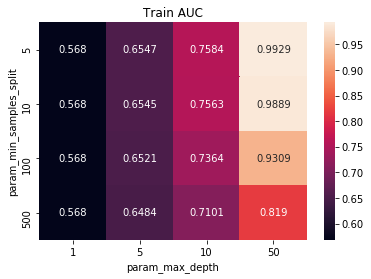

In [21]:
scores = pd.DataFrame(DT_tfidf.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score','mean_train_score']]
sns.heatmap(scores.mean_train_score, annot = True, fmt='.4g')

plt.title('Train AUC')

plt.show()

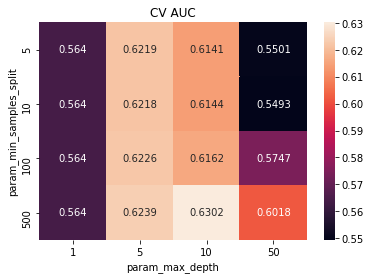

In [22]:
sns.heatmap(scores.mean_test_score, annot = True, fmt='.4g')
plt.title('CV AUC')
plt.show()

# Performance of the model using heatmap (TFIDF - W2V)

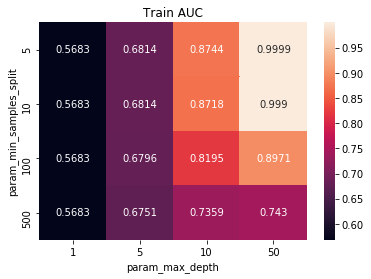

In [23]:
scores = pd.DataFrame(DT_tfidfw2v.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score','mean_train_score']]
sns.heatmap(scores.mean_train_score, annot = True, fmt='.4g')

plt.title('Train AUC')

plt.show()

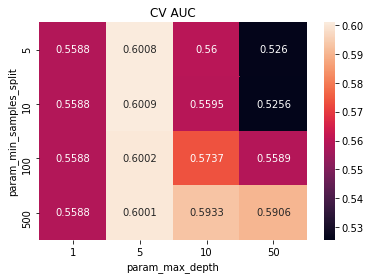

In [24]:
sns.heatmap(scores.mean_test_score, annot = True, fmt='.4g')
plt.title('CV AUC')
plt.show()

# ROC curve and best AUC score(TFIDF)

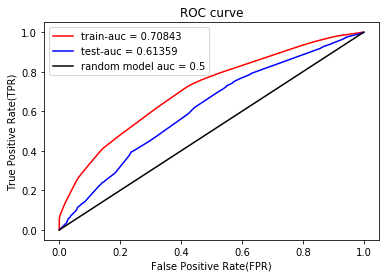

Best AUC for the model is 0.61359 


In [71]:
clf = DecisionTreeClassifier(class_weight='balanced',max_depth=10,min_samples_split=500)
clf.fit(X_train_tfidf,y_train)


y_pred_train = clf.predict_proba(X_train_tfidf)
y_pred_test = clf.predict_proba(X_test_tfidf)

#taking the probabilit scores instead of the predicted label
#predict_proba returns probabilty scores which is in the 2nd column thus taking the second column
fpr_train,tpr_train,threshold_train = roc_curve(y_train,y_pred_train[:,1])
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_pred_test[:,1])

train_auc = round(auc(fpr_train,tpr_train),5)
test_auc = round(auc(fpr_test,tpr_test),5)

plt.plot(fpr_train,tpr_train,color='red',label='train-auc = '+str(train_auc))
plt.plot(fpr_test,tpr_test,color='blue',label='test-auc = '+str(test_auc))
plt.plot(np.array([0,1]),np.array([0,1]),color='black',label='random model auc = '+str(0.5))
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC curve')
plt.legend()
plt.show()
print('Best AUC for the model is {} '.format(test_auc))

# Confusion Matrix (TFIDF)

In [72]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(fpr*(1-tpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.3441257993408848 for threshold 0.533


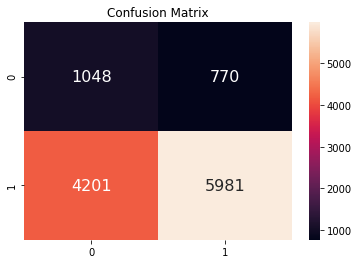

In [73]:
predicted = predict(y_pred_test[:,1],threshold_test,fpr_test,tpr_test)
confusion_matrix_test = pd.DataFrame(confusion_matrix(y_test,predicted))
sns.heatmap(confusion_matrix_test,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')
plt.show()

# False Positive Data points(TFIDF)

In [74]:
fp_index = [idx for idx in range(len(y_test)) if (y_test.values[idx]==0 and predicted[idx]==1)]
false_positive = []
for idx in fp_index:
    false_positive.append(X_test['essay'].values[idx])


# WordCloud TFIDF

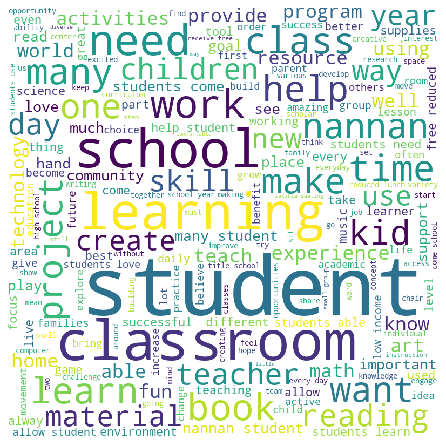

In [75]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in false_positive :
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    for words in tokens :
        comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,min_font_size = 10).generate(comment_words)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


# Box Plot on Price of False Positive TFIDF

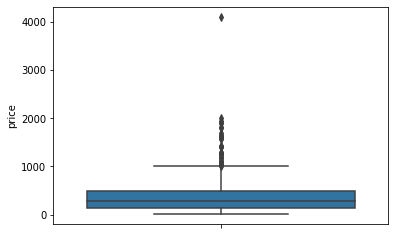

In [76]:
#creating a data frame having all data about false positive indexes
false_pos_df = X_test.iloc[fp_index]
sns.boxplot(y='price',data=false_pos_df)
plt.show()

#  Pdf with the teacher_number_of_previously_posted_projects  of false positive data points

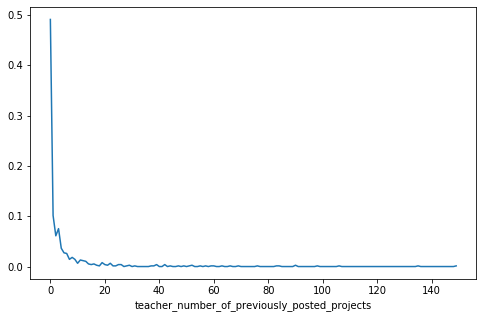

In [77]:
plt.figure(figsize=(8,5))
counts, bin_edges = np.histogram(false_pos_df['teacher_number_of_previously_posted_projects'],bins='auto', density=True)
pdf = counts/sum(counts)
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.plot(pdf)
plt.show()

# ROC curve and best AUC score(TFIDF W2V)

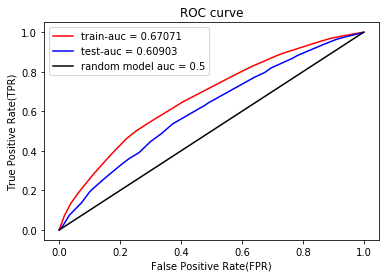

Best AUC for the model is 0.60903 


In [78]:
clf = DecisionTreeClassifier(class_weight='balanced',max_depth=5,min_samples_split=10)
clf.fit(X_train_tfidfw2v,y_train)

y_pred_train = clf.predict_proba(X_train_tfidfw2v)
y_pred_test = clf.predict_proba(X_test_tfidfw2v)

#taking the probabilit scores instead of the predicted label
#predict_proba returns probabilty scores which is in the 2nd column thus taking the second column
fpr_train,tpr_train,threshold_train = roc_curve(y_train,y_pred_train[:,1])
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_pred_test[:,1])

train_auc = round(auc(fpr_train,tpr_train),5)
test_auc = round(auc(fpr_test,tpr_test),5)

plt.plot(fpr_train,tpr_train,color='red',label='train-auc = '+str(train_auc))
plt.plot(fpr_test,tpr_test,color='blue',label='test-auc = '+str(test_auc))
plt.plot(np.array([0,1]),np.array([0,1]),color='black',label='random model auc = '+str(0.5))
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC curve')
plt.legend()
plt.show()
print('Best AUC for the model is {} '.format(test_auc))

# Confusion Matrix (TFIDF W2V)

the maximum value of tpr*(1-fpr) 0.336612972827434 for threshold 0.486


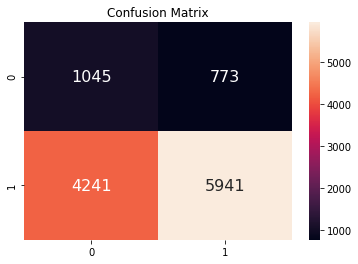

In [79]:
predicted = predict(y_pred_test[:,1],threshold_test,fpr_test,tpr_test)
confusion_matrix_test = pd.DataFrame(confusion_matrix(y_test,predicted))
sns.heatmap(confusion_matrix_test,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')
plt.show()

# False Positive Data points(TFIDF-W2V)

In [80]:
fp_index = [idx for idx in range(len(y_test)) if (y_test.values[idx]==0 and predicted[idx]==1)]
false_positive = []
for idx in fp_index:
    false_positive.append(X_test['essay'].values[idx])


# WordCLoud (TFIDF-W2V) False_positive

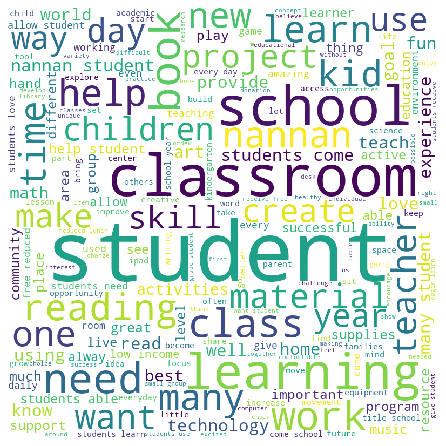

In [81]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in false_positive :
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    for words in tokens :
        comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,min_font_size = 10).generate(comment_words)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


# Box on Plot Price of False Positive TFIDF W2V

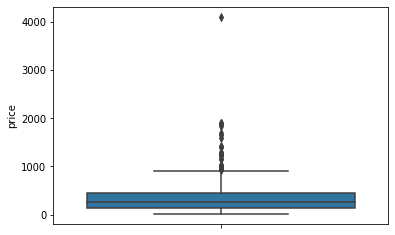

In [82]:
#creating a data frame having all data about false positive indexes
false_pos_df = X_test.iloc[fp_index]
sns.boxplot(y='price',data=false_pos_df)
plt.show()

#  Pdf with the teacher_number_of_previously_posted_projects  of false positive data points

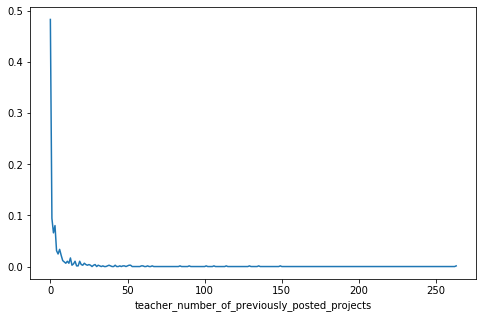

In [83]:
plt.figure(figsize=(8,5))
counts, bin_edges = np.histogram(false_pos_df['teacher_number_of_previously_posted_projects'],bins='auto', density=True)
pdf = counts/sum(counts)
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.plot(pdf)
plt.show()

<h2>1.6 Getting top features using `feature_importances_`</h2>

In [85]:
#keeping the max depth for the model to be none
model = DecisionTreeClassifier(class_weight='balanced',max_depth=None,min_samples_split=500)
model.fit(X_train_tfidf,y_train)
X_tr = pd.DataFrame.sparse.from_spmatrix(X_train_tfidf)
X_tst = pd.DataFrame.sparse.from_spmatrix(X_test_tfidf)
feature_importance = model.feature_importances_
ft_index = []
for idx,val in np.ndenumerate(feature_importance):
    if val == 0:
        ft_index.append(idx[0])

#dropping the useless features from both train and test data
X_tr = X_tr.drop(ft_index,axis=1)
X_tst = X_tst.drop(ft_index,axis=1)

In [86]:
#final dim of the data set reduced to 324 features from 6601 features
print(X_tr.shape,X_tst.shape)

(28000, 324) (12000, 324)


# Applying Decision Tree

**Hyperparameter tunning**

In [90]:
DT = DecisionTreeClassifier(class_weight='balanced')
param = {'max_depth':  [1, 5, 10, 50],'min_samples_split': [5, 10, 100, 500]}
clf = GridSearchCV(DT,param,return_train_score=True,scoring='roc_auc')
clf.fit(X_tr,y_train)


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid

In [93]:
print('Best value of hyperparameter is max_depth is {} and min_samples_split = {}'.format(clf.best_params_['max_depth'],clf.best_params_['min_samples_split']))

Best value of hyperparameter is max_depth is 10 and min_samples_split = 500


# Performance of the model shown using heatmap

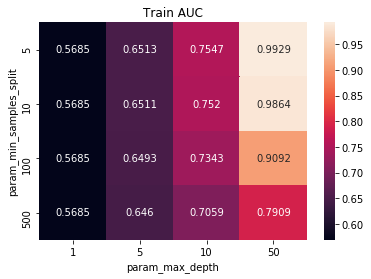

In [96]:
scores = pd.DataFrame(clf.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score','mean_train_score']]
sns.heatmap(scores.mean_train_score, annot = True, fmt='.4g')

plt.title('Train AUC')

plt.show()

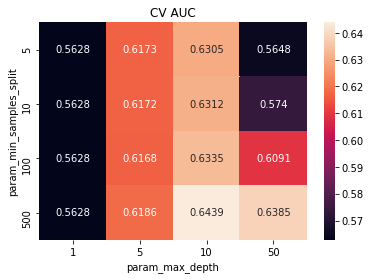

In [97]:
sns.heatmap(scores.mean_test_score, annot = True, fmt='.4g')
plt.title('CV AUC')
plt.show()

# ROC curve and AUC score of the model with best hyperparameter

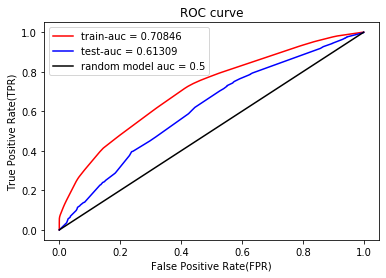

Best AUC for the model is 0.61309 


In [116]:
DT = DecisionTreeClassifier(class_weight='balanced',max_depth=10,min_samples_split=500)
DT.fit(X_tr,y_train)

y_pred_train = clf.predict_proba(X_tr)
y_pred_test = clf.predict_proba(X_tst)

#taking the probabilit scores instead of the predicted label
#predict_proba returns probabilty scores which is in the 2nd column thus taking the second column
fpr_train,tpr_train,threshold_train = roc_curve(y_train,y_pred_train[:,1])
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_pred_test[:,1])

train_auc = round(auc(fpr_train,tpr_train),5)
test_auc = round(auc(fpr_test,tpr_test),5)

plt.plot(fpr_train,tpr_train,color='red',label='train-auc = '+str(train_auc))
plt.plot(fpr_test,tpr_test,color='blue',label='test-auc = '+str(test_auc))
plt.plot(np.array([0,1]),np.array([0,1]),color='black',label='random model auc = '+str(0.5))
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC curve')
plt.legend()
plt.show()
print('Best AUC for the model is {} '.format(test_auc))

# Confusion Matrix

the maximum value of tpr*(1-fpr) 0.34371663448018347 for threshold 0.533


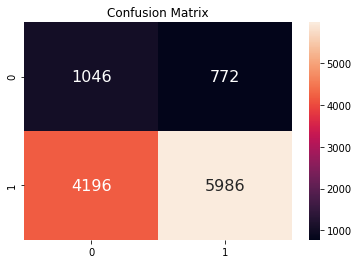

In [117]:
predicted = predict(y_pred_test[:,1],threshold_test,fpr_test,tpr_test)
confusion_matrix_test = pd.DataFrame(confusion_matrix(y_test,predicted))
sns.heatmap(confusion_matrix_test,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')
plt.show()

# False Positive Data point

In [118]:
fp_index = [idx for idx in range(len(y_test)) if (y_test.values[idx]==0 and predicted[idx]==1)]
false_positive = []
for idx in fp_index:
    false_positive.append(X_test['essay'].values[idx])

# WordCLoud

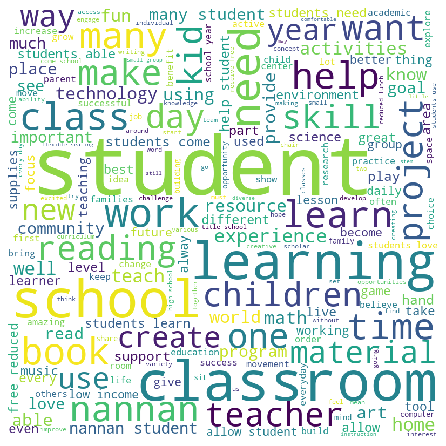

In [119]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in false_positive :
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    for words in tokens :
        comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,min_font_size = 10).generate(comment_words)

plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


# Box on Plot Price of False Positive

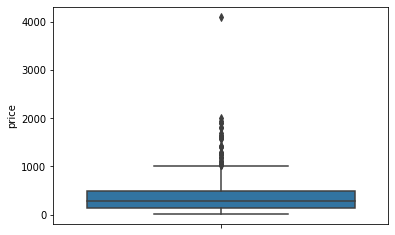

In [120]:
#creating a data frame having all data about false positive indexes
false_pos_df = X_test.iloc[fp_index]
sns.boxplot(y='price',data=false_pos_df)
plt.show()

#  Pdf with the teacher_number_of_previously_posted_projects  of false positive data points

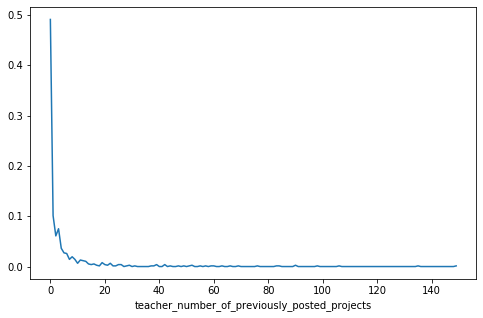

In [121]:
plt.figure(figsize=(8,5))
counts, bin_edges = np.histogram(false_pos_df['teacher_number_of_previously_posted_projects'],bins='auto', density=True)
pdf = counts/sum(counts)
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.plot(pdf)
plt.show()

<h1>2. Summary</h1>

In [122]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names= (" Vectorizer ", " Max_depth ", " Min_sample_split "," Test -AUC ")
table.add_row([" Tf-Idf", 10 , 500 ,0.61359])
table.add_row(["Tf-Idf W2V", 5 , 10 ,0.60903])
table.add_row(["Top Features", 10, 500 ,0.61309])
print(tb.get_string(titles = "Decision trees- Observations")) 

+--------------+-------------+--------------------+-------------+
|  Vectorizer  |  Max_depth  |  Min_sample_split  |  Test -AUC  |
+--------------+-------------+--------------------+-------------+
|   Tf - Idf   |      10     |        500         |   0.61359   |
| Tf - Idf W2V |      5      |         10         |   0.60903   |
| Top Features |      10     |        500         |   0.61309   |
+--------------+-------------+--------------------+-------------+
